In [32]:
# sphinx_gallery_thumbnail_path = "../../gallery/assets/visualization_utils_thumbnail2.png"

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'
%matplotlib inline
%config InlineBackend.figure_format='retina'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [33]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True, progress=False)
model = model.eval()

In [41]:
from models import utils
train_dir="/net/scratch/hanliu-shared/data/BIRD/train/"
valid_dir="/net/scratch/hanliu-shared/data/BIRD/valid"
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=utils.bm_transform())
valid_dataset = torchvision.datasets.ImageFolder(valid_dir, transform=utils.bm_transform())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=10)

In [55]:
k=3
normalized_batch = next(iter(train_loader))[0]
batch = normalized_batch

In [56]:
output = model(normalized_batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([10, 21, 224, 224]) -4.90867280960083 12.968619346618652


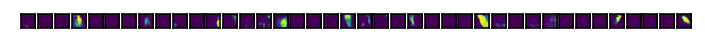

In [58]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(batch.shape[0])
    for cls in ('dog', 'boat', 'cat', 'bird')
]

show(dog_and_boat_masks)

shape = torch.Size([10, 224, 224]), dtype = torch.bool


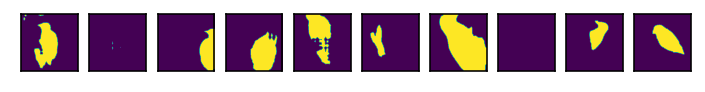

In [59]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['bird'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

In [60]:
from skimage.segmentation import slic

In [69]:
x = normalized_batch[0].numpy()
x = np.rollaxis(x, 0, 3)

In [75]:
mask = slic(x, n_segments=100)

<ipython-input-75-fc51ddbc0026>:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  mask = slic(x, n_segments=100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


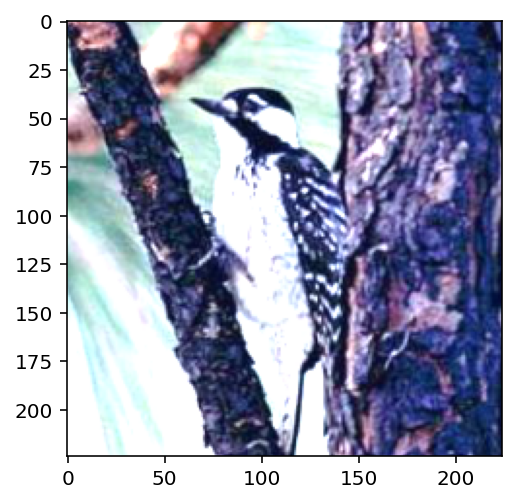

In [78]:
plt.imshow((x - x.min()) / x.max())